下面用代码实现循环神经网络。首先读取数据，使用《小王子》这本书作为训练语料。

115


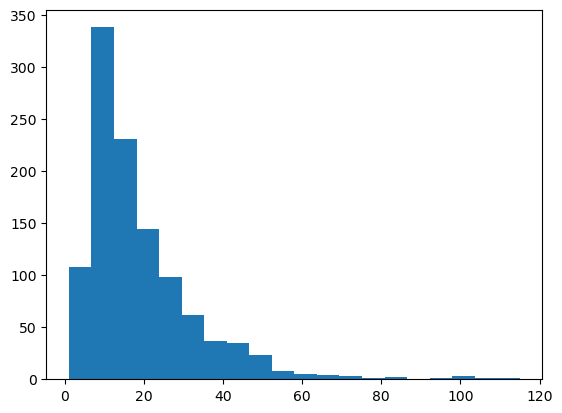

In [1]:
import os
import sys

# 导入前面实现的小王子数据集
sys.path.append('./code')
from utils import TheLittlePrinceDataset

dataset = TheLittlePrinceDataset()

# 统计每句话的长度
sent_lens = []
max_len = -1
for sentence in dataset.tokens:
    sent_len = len(sentence)
    sent_lens.append(sent_len)
    if sent_len > max_len:
        max_len = sent_len
        longest = sentence
print(max_len)

# 简单看一下语料中序列长度的分布
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)
plt.show()

接下来建立词表，截断过长的序列，将序列填充（padding）到相同长度。

In [2]:
import numpy as np

dataset.build_vocab()
sent_tokens = dataset.convert_tokens_to_ids()
# 截断和填充
max_len=40
for i, tokens in enumerate(sent_tokens):
    tokens = tokens[:max_len]
    tokens += [dataset.token2id['<pad>']] * (max_len - len(tokens))
    sent_tokens[i] = tokens
sent_tokens = np.array(sent_tokens)

print(len(dataset.tokens), max([len(x) for x in dataset.tokens]))
print(sent_tokens.shape)
print(sent_tokens[0])

1105 115
(1104, 40)
[  4  17  20 742 743 744 742 743 744   2  62  19   9   1   1   2   1  10
 745 746   4  17  20  21   1   2  30 335 194  33 299   3   0   0   0   0
   0   0   0   0]


In [3]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
import torch
from torch import nn
import torch.nn.functional as F

# 定义一个正态分布的函数用于初始化参数
def normal(shape):
    return torch.randn(size=shape) * 0.01

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 将输入与隐状态分别经过线性变化后相加
        self.W_xh = nn.Parameter(normal((input_size, hidden_size)))
        self.W_hh = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
    
    def init_rnn_state(self, batch_size, hidden_size):
        return (torch.zeros((batch_size, hidden_size), dtype=torch.float),)
    
    def forward(self, inputs, states):
        seq_len, batch_size, _ = inputs.shape
        hidden_state, = states
        hiddens = []
        for step in range(seq_len):
            # 输入hidden_state与inputs经过线性变换后相加，
            # 输出的hidden_state也是下一时刻输入的hidden_state
            xh = torch.mm(inputs[step], self.W_xh)
            hh = torch.mm(hidden_state, self.W_hh)
            hidden_state = xh + hh + self.b_h
            hidden_state = torch.tanh(hidden_state)
            hiddens.append(hidden_state)
        # 返回所有时刻的hidden_state: seq_len * batch_size * hidden_size
        # 以及最后时刻的hidden_state（可能用于后续输入）: 
        # batch_size * hidden_size
        return torch.stack(hiddens, dim=0), (hidden_state,)

# 在循环神经网络的基础上添加语言模型的输入输出、损失计算等
class RNNLM(nn.Module):
    def __init__(self, model, vocab_size, hidden_size):
        super(RNNLM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.model = model
        self.W_hq = nn.Parameter(normal((hidden_size, vocab_size)))
        self.b_q = nn.Parameter(torch.zeros(vocab_size))
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        # input_ids形状为batch_size * seq_len，翻转为seq_len * batch_size，
        # 将seq_len放在第一维方便计算
        input_ids = torch.permute(input_ids, (1, 0))
        # seq_len * batch_size * embed_size
        embed = self.embedding(input_ids)
        # batch_size * hidden_size
        states = self.model.init_rnn_state(batch_size, self.hidden_size)
        hiddens, _ = self.model(embed, states)
    
        hiddens = torch.flatten(hiddens[:-1], start_dim=0, end_dim=1)
        output_states = torch.mm(hiddens, self.W_hq) + self.b_q
        labels = torch.flatten(input_ids[1:], start_dim=0, end_dim=1)
        loss_fct = nn.CrossEntropyLoss(ignore_index=0)
        loss = loss_fct(output_states, labels)
        return loss

下面展示使用梯度裁剪的循环神经网络语言模型的训练代码。

(1104, 40)


epoch-199, loss=0.3491: 100%|█| 200/200 [04:42<00:00,  1.41s


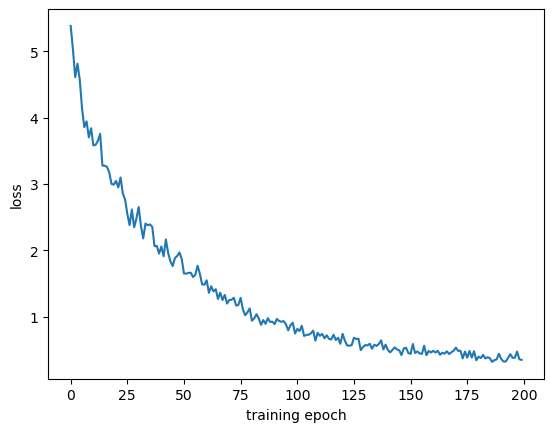

In [6]:
# 梯度裁剪
def grad_clipping(model, theta=1):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
    

# 训练
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

def train_rnn_lm(data_loader, rnn, vocab_size, hidden_size=128, 
                 epochs=200, learning_rate=1e-3):
    # 准备模型、优化器等
    rnn_lm = RNNLM(rnn, vocab_size, hidden_size)
    optimizer = Adam(rnn_lm.parameters(), lr=learning_rate)
    rnn_lm.zero_grad()
    rnn_lm.train()

    epoch_loss = []
    with trange(epochs, desc='epoch', ncols=60) as pbar:
        for epoch in pbar:
            for step, batch in enumerate(data_loader):
                loss = rnn_lm(batch)
                pbar.set_description(f'epoch-{epoch}, ' + \
                    f'loss={loss.item():.4f}')
                loss.backward()
                grad_clipping(rnn_lm)
                optimizer.step()
                rnn_lm.zero_grad()
            epoch_loss.append(loss.item())

    epoch_loss = np.array(epoch_loss)
    # 打印损失曲线
    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.xlabel('training epoch')
    plt.ylabel('loss')
    plt.show()

sent_tokens = np.array(sent_tokens)
print(sent_tokens.shape)
vocab_size = len(dataset.token2id)

data_loader = DataLoader(torch.tensor(sent_tokens, dtype=torch.long),\
    batch_size=16, shuffle=True)
rnn = RNN(128, 128)
train_rnn_lm(data_loader, rnn, vocab_size, hidden_size=128,\
    epochs=200, learning_rate=1e-3)

接下来仿照循环神经网络实现长短期记忆，同样的接口使得我们可以重用之前的训练代码。

epoch-199, loss=0.2949: 100%|█| 200/200 [12:22<00:00,  3.71s


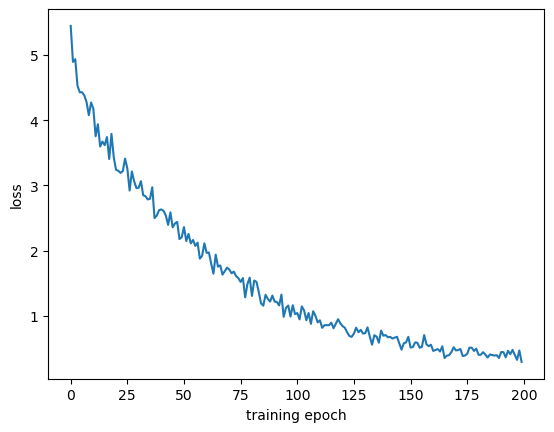

In [7]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
# 长短期记忆
def gate_params(input_size, hidden_size):
    return (nn.Parameter(normal((input_size, hidden_size))),
           nn.Parameter(normal((hidden_size, hidden_size))),
           nn.Parameter(torch.zeros(hidden_size)))

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 输入门参数
        self.W_xi, self.W_hi, self.b_i = gate_params(input_size, hidden_size)
        # 遗忘门参数
        self.W_xf, self.W_hf, self.b_f = gate_params(input_size, hidden_size)
        # 输出门参数
        self.W_xo, self.W_ho, self.b_o = gate_params(input_size, hidden_size)
        # 候选记忆单元参数
        self.W_xc, self.W_hc, self.b_c = gate_params(input_size, hidden_size)
        
    def init_rnn_state(self, batch_size, hidden_size):
        return (torch.zeros((batch_size, hidden_size), dtype=torch.float),
               torch.zeros((batch_size, hidden_size), dtype=torch.float))
    
    def forward(self, inputs, states):
        seq_len, batch_size, _ = inputs.shape
        hidden_state, cell_state = states
        hiddens = []
        for step in range(seq_len):
            I = torch.sigmoid(torch.mm(inputs[step], self.W_xi) \
                + torch.mm(hidden_state, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.mm(inputs[step], self.W_xf) \
                + torch.mm(hidden_state, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.mm(inputs[step], self.W_xo) \
                + torch.mm(hidden_state, self.W_ho) + self.b_o)
            C_tilda = torch.tanh(torch.mm(inputs[step], self.W_xc) \
                + torch.mm(hidden_state, self.W_hc) + self.b_c)
            cell_state = F * cell_state + I * C_tilda
            hidden_state = O * torch.tanh(cell_state)
            hiddens.append(hidden_state)
        return torch.stack(hiddens, dim=0), (hidden_state, cell_state)
    
data_loader = DataLoader(torch.tensor(sent_tokens, dtype=torch.long), 
    batch_size=16, shuffle=True)

lstm = LSTM(128, 128)
train_rnn_lm(data_loader, lstm, vocab_size, hidden_size=128, epochs=200, 
    learning_rate=1e-3)

下面仿照长短期记忆实现门控循环单元。

epoch-199, loss=0.2947: 100%|█| 200/200 [11:40<00:00,  3.50s


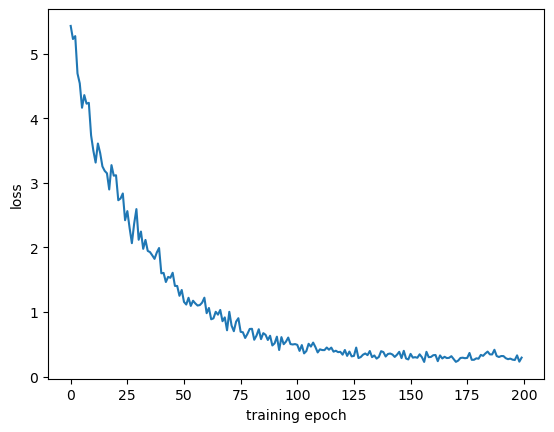

In [8]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
# 门控循环单元
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 更新门参数
        self.W_xu, self.W_hu, self.b_u = gate_params(input_size, hidden_size)
        # 重置门参数
        self.W_xr, self.W_hr, self.b_r = gate_params(input_size, hidden_size)
        # 候选隐状态参数
        self.W_xh, self.W_hh, self.b_h = gate_params(input_size, hidden_size)
        
    def init_rnn_state(self, batch_size, hidden_size):
        return (torch.zeros((batch_size, hidden_size), dtype=torch.float),)
    
    def forward(self, inputs, states):
        seq_len, batch_size, _ = inputs.shape
        hidden_state, = states
        hiddens = []
        for step in range(seq_len):
            U = torch.sigmoid(torch.mm(inputs[step], self.W_xu)\
                + torch.mm(hidden_state, self.W_hu) + self.b_u)
            R = torch.sigmoid(torch.mm(inputs[step], self.W_xr)\
                + torch.mm(hidden_state, self.W_hr) + self.b_r)
            H_tilda = torch.tanh(torch.mm(inputs[step], self.W_xh)\
                + torch.mm(R * hidden_state, self.W_hh) + self.b_h)
            hidden_state = (1 - U) * hidden_state + U * H_tilda
            hiddens.append(hidden_state)
        return torch.stack(hiddens, dim=0), (hidden_state,)
    
data_loader = DataLoader(torch.tensor(sent_tokens, dtype=torch.long), 
    batch_size=16, shuffle=True)

gru = GRU(128, 128)
train_rnn_lm(data_loader, gru, vocab_size, hidden_size=128, epochs=200, 
    learning_rate=1e-3)

下面在循环神经网络的基础上实现多层循环神经网络。

epoch-199, loss=0.4688: 100%|█| 200/200 [07:18<00:00,  2.19s


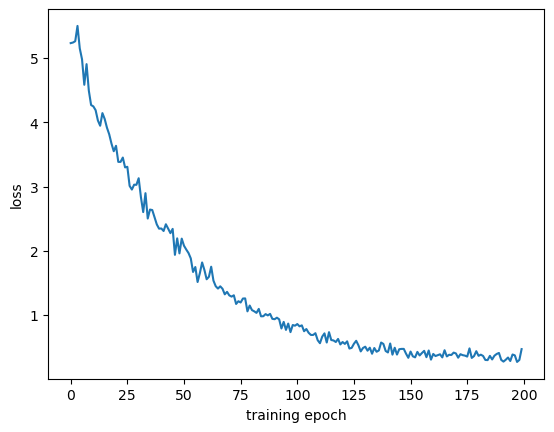

In [9]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
# 多层循环神经网络
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.):
        super(DeepRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self._flat_weight_names = []
        self._all_weights = []
        self.drop = nn.Dropout(p=dropout)
        # 定义每一层循环神经网络的参数，由于参数数量不固定，
        # 因此使用统一的命名方法更方便调用和管理
        for layer in range(num_layers):
            W_xh = nn.Parameter(normal((input_size, hidden_size)))
            W_hh = nn.Parameter(normal((hidden_size, hidden_size)))
            b_h = nn.Parameter(torch.zeros(hidden_size))
            layer_params = (W_xh, W_hh, b_h)
            params_names = [f'W_xh_l{layer}', f'W_hh_l{layer}', \
                f'b_h_l{layer}']
            
            # 将新的参数加入到成员列表中
            for name, param in zip(params_names, layer_params):
                setattr(self, name, param)
            self._flat_weight_names.extend(params_names)
            self._all_weights.append(params_names)
            input_size = hidden_size
        self._flat_weights = [getattr(self, wn) if hasattr(self, wn) \
            else None for wn in self._flat_weight_names]
    
    def __setattr__(self, attr, value):
        if hasattr(self, '_flat_weight_names') and \
            attr in self._flat_weight_names:
            idx = self._flat_weight_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)
    
    def init_rnn_state(self, batch_size, hidden_size):
        return (torch.zeros((self.num_layers, batch_size, hidden_size), 
            dtype=torch.float),)
    
    def forward(self, inputs, states):
        seq_len, batch_size, _ = inputs.shape
        layer_hidden_states, = states
        layer_h_t = []
        input_states = inputs
        # 需要保存每一层的输出作为下一层的输入
        for layer in range(self.num_layers):
            hiddens = []
            hidden_state = layer_hidden_states[layer]
            for step in range(seq_len):
                xh = torch.mm(input_states[step], 
                    getattr(self, f'W_xh_l{layer}'))
                hh = torch.mm(hidden_state, getattr(self, f'W_hh_l{layer}'))
                hidden_state = xh + hh + getattr(self, f'b_h_l{layer}')
                hidden_state = self.drop(torch.tanh(hidden_state))
                hiddens.append(hidden_state)
            input_states = torch.stack(hiddens, dim=0)
            layer_h_t.append(hidden_state)
        return input_states, torch.stack(layer_h_t, dim=0)

data_loader = DataLoader(torch.tensor(sent_tokens, dtype=torch.long), 
    batch_size=16, shuffle=True)
deep_rnn = DeepRNN(128, 128, 2)
train_rnn_lm(data_loader, deep_rnn, vocab_size, hidden_size=128, 
    epochs=200, learning_rate=1e-3)



需要注意的是，双向循环神经网络在每个位置的输出同时包含了来自左边和右边的信息，也就是整个输入序列的信息。所以双向循环神经网络并不能用于语言模型，因为语言模型需要仅根据序列中每个词左边的信息来预测这个词。

下面的双向循环神经网络是一个简单的示例，要求一次只能输入一个序列。如果想在一个批次中并行处理不同长度的输入序列以获得更高的运行效率，可以通过填充将不同长度的输入对齐。单向循环神经网络的填充较为简单，只需在每个序列末尾添加字符就可以。但是双向循环神经网络的填充更加复杂，正向和反向循环神经网络的读取顺序相反，难以保证两个方向的循环神经网络都填充在末尾，实现起来较为困难。
解决方案参考PyTorch中的pack_padded_sequence和pad_packed_sequence。双向循环神经网络不能用于训练语言模型，因此不再提供训练示例代码。

In [10]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
# 双向循环神经网络
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 正向循环神经网络参数
        self.W_xh = nn.Parameter(normal((input_size, hidden_size)))
        self.W_hh = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        # 反向循环神经网络参数
        self.W_xh_reverse = nn.Parameter(normal((input_size, hidden_size)))
        self.W_hh_reverse = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_h_reverse = nn.Parameter(torch.zeros(hidden_size))
        
    # 分别为正向和反向循环神经网络准备初始状态
    def init_rnn_state(self, batch_size, hidden_size):
        return (torch.zeros((batch_size, hidden_size), dtype=torch.float),
               torch.zeros((batch_size, hidden_size), dtype=torch.float))
    
    def forward(self, inputs, states):
        seq_len, batch_size, _ = inputs.shape
        hidden_state, reverse_hidden_state = states
        hiddens = []
        for step in range(seq_len):
            xh = torch.mm(inputs[step], self.W_xh)
            hh = torch.mm(hidden_state, self.W_hh)
            hidden_state = xh + hh + self.b_h
            hidden_state = torch.tanh(hidden_state)
            hiddens.append(hidden_state)
        reverse_hiddens = []
        for step in range(seq_len-1, -1, -1):
            xh = torch.mm(inputs[step], self.W_xh_reverse)
            hh = torch.mm(reverse_hidden_state, self.W_hh_reverse)
            reverse_hidden_state = xh + hh + self.b_h_reverse
            reverse_hidden_state = torch.tanh(reverse_hidden_state)
            reverse_hiddens.insert(0, reverse_hidden_state)
        # 将正向和反向循环神经网络输出的隐状态拼接在一起
        combined_hiddens = []
        for h1, h2 in zip(hiddens, reverse_hiddens):
            combined_hiddens.append(torch.cat([h1, h2], dim=-1))
        return torch.stack(combined_hiddens, dim=0), ()

下面实现一个带有缩放点乘注意力的循环神经网络，并用其训练语言模型。

epoch-199, loss=0.9967: 100%|█| 200/200 [09:11<00:00,  2.76s


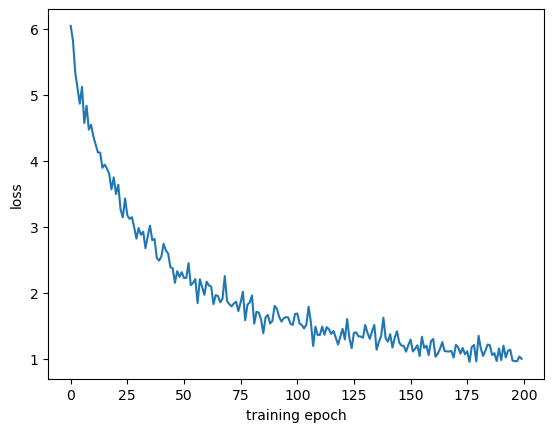

In [11]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
class AttentionRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AttentionRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 循环神经网络参数
        self.W_xh = nn.Parameter(normal((input_size, hidden_size)))
        self.W_hh = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
    
    def init_rnn_state(self, batch_size, hidden_size):
        return (torch.zeros((batch_size, hidden_size),\
            dtype=torch.float),)
    
    # 缩放点乘注意力
    def attention(self, query, keys, values):
        """
        query: batch_size * hidden_size
        keys/values: batch_size * prev_len * hidden_size
        """
        # batch_size * 1 * hidden_size
        query = torch.unsqueeze(query, 1)
        # batch_size * hidden_size * prev_len
        keys = torch.permute(keys, (0, 2, 1))
        # batch_size * 1 * prev_len
        attention_scores = torch.bmm(query, keys) / np.sqrt(\
            self.hidden_size)
        # batch_size * 1 * prev_len
        attention_weights = F.softmax(attention_scores, dim=1)
        # batch_size * hidden_size
        attention_state = torch.squeeze(torch.bmm(attention_weights,\
            values))
        return attention_state

    def forward(self, inputs, states):
        seq_len, batch_size, _ = inputs.shape
        hidden_state, = states
        hiddens = []
        attention_hiddens = []
        for step in range(seq_len):
            xh = torch.mm(inputs[step], self.W_xh)
            hh = torch.mm(hidden_state, self.W_hh)
            hidden_state = xh + hh + self.b_h
            hidden_state = torch.tanh(hidden_state)
            
            if step > 0:
                # batch_size * hidden_size
                query = hidden_state
                # batch_size * prev_len * hidden_size
                keys = values = torch.permute(torch.stack(hiddens,\
                    dim=0), (1, 0, 2))
                
                attention_state = self.attention(query, keys, values)                
                attention_hiddens.append(attention_state)
            else:
                # 第0步，历史隐状态为空，无法进行注意力运算，
                # 直接用隐状态填充
                attention_hiddens.append(hidden_state)
                
            hiddens.append(hidden_state)
        return torch.stack(attention_hiddens, dim=0), \
            (attention_state,)
    
data_loader = DataLoader(torch.tensor(sent_tokens, dtype=torch.long), 
    batch_size=16, shuffle=True)

attention_rnn = AttentionRNN(128, 128)
train_rnn_lm(data_loader, attention_rnn, vocab_size, hidden_size=128, 
    epochs=200, learning_rate=1e-3)

下面是多头注意力的代码实现。我们在实现AttentionRNN时将注意力计算封装在成员函数里面，因此实现多头注意力时可以直接继承AttentionRNN类，只用改写构造函数和attention()成员方法即可。

epoch-199, loss=1.1583: 100%|█| 200/200 [21:31<00:00,  6.46s


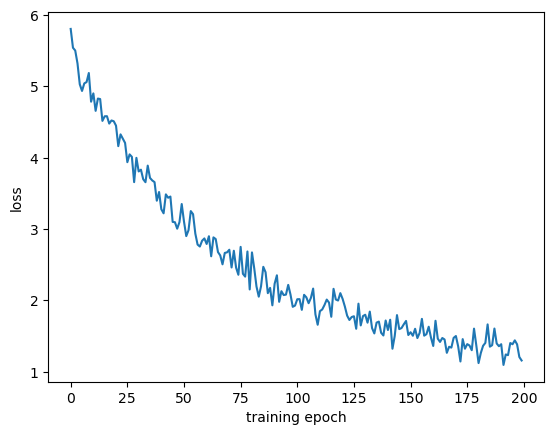

In [12]:
"""
部分代码参考了GitHub项目d2l-ai/d2l-zh的思路
（Copyright (c) 2022 Aston Zhang, Zachary C. Lipton,
Mu Li, and Alexander J. Smola, Apache-2.0 License（见附录））
"""
# 多头注意力循环神经网络
class MultiHeadAttentionRNN(AttentionRNN):
    def __init__(self, input_size, hidden_size, num_heads=4):
        super().__init__(input_size, hidden_size)
        # 简单起见，一般要求hidden_size能够被num_heads整除
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        # 多头注意力参数，用于将查询、键、值映射到子空间
        self.W_aq = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_aq = nn.Parameter(torch.zeros(hidden_size))
        self.W_ak = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_ak = nn.Parameter(torch.zeros(hidden_size))
        self.W_av = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_av = nn.Parameter(torch.zeros(hidden_size))
        self.W_ac = nn.Parameter(normal((hidden_size, hidden_size)))
        self.b_ac = nn.Parameter(torch.zeros(hidden_size))

    # 多头缩放点乘注意力
    def attention(self, query, keys, values):
        """
        query: batch_size * hidden_size
        keys/values: batch_size * prev_len * hidden_size
        """
        query = torch.mm(query, self.W_aq) + self.b_aq
        ori_shape = keys.size()
        
        keys = torch.reshape(torch.mm(torch.flatten(keys, 
                start_dim=0, end_dim=1), self.W_ak) + 
                self.b_ak, ori_shape)
        values = torch.reshape(torch.mm(torch.flatten(values, 
                start_dim=0, end_dim=1), self.W_av) + 
                self.b_av, ori_shape)
        # batch_size * 1 * hidden_size
        query = torch.unsqueeze(query, 1)
        # batch_size * hidden_size * prev_len
        keys = torch.permute(keys, (0, 2, 1))
        
        head_size = self.hidden_size // self.num_heads
        query = torch.split(query, head_size, 2)
        keys = torch.split(keys, head_size, 1)
        values = torch.split(values, head_size, 2)
        
        heads = []
        for i in range(self.num_heads):
            # batch_size * 1 * prev_len
            head_scores = torch.bmm(query[i], keys[i]) / np.sqrt(
                self.hidden_size // self.num_heads) 
            # batch_size * 1 * prev_len
            head_weights = F.softmax(head_scores, dim=1)
            # batch_size * head_size
            head_state = torch.squeeze(torch.bmm(head_weights, 
                values[i])) 
            heads.append(head_state)
        heads = torch.cat(heads, dim=1)        
        attention_state = torch.mm(heads, self.W_ac) + self.b_ac

        return attention_state

data_loader = DataLoader(torch.tensor(sent_tokens, 
    dtype=torch.long), batch_size=16, shuffle=True)

mha_rnn = MultiHeadAttentionRNN(128, 128)
train_rnn_lm(data_loader, mha_rnn, vocab_size, hidden_size=128, 
    epochs=200, learning_rate=1e-3)

下面来实现Transformer模型，包括加入了位置编码的嵌入层、缩放点乘注意力、多头注意力、层归一化等具体实现。

In [13]:
"""
代码修改自GitHub项目huggingface/transformers
（Copyright (c) 2020, The HuggingFace Team, Apache-2.0 License（见附录））
"""
# 实现Transformer模型
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, max_len, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_len, embed_size)
        
    def forward(self, input_ids, pos_ids):
        """
        input_ids/pos_ids: batch_size * seq_len
        return: batch_size * seq_len * embed_size
        """
        word_embed = self.word_embedding(input_ids)
        pos_embed = self.pos_embedding(pos_ids)
        # 将词嵌入和位置嵌入相加得到嵌入层输出
        return word_embed + pos_embed

# 缩放点乘注意力
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, attention_mask):
        """
        queries/keys/values: batch_size * seq_len * hidden_size
        attention_mask: batch_size * seq_len * seq_len
        return: batch_size * seq_len * hidden_size
        """
        d = queries.size(-1)
        # 根据点乘注意力的矩阵形式计算注意力分数，除以查询向量或键向量
        # 维度的平方根，即为缩放点乘注意力
        scores = torch.bmm(queries, torch.transpose(keys, 1, 2)) / np.sqrt(d)
        # 将掩码为0的位置的注意力分数设为一个大负数，根据softmax函数
        # 的性质，这些注意力分数归一化后接近0
        scores[attention_mask == 0] = -1e6
        self.attention_weights = F.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)
    
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.W_q = nn.Linear(hidden_size, hidden_size)
        self.W_k = nn.Linear(hidden_size, hidden_size)
        self.W_v = nn.Linear(hidden_size, hidden_size)
        self.W_o = nn.Linear(hidden_size, hidden_size)
        self.attention = ScaledDotProductAttention(dropout)
    
    def transpose_qkv(self, states):
        # 将长度为hidden_size的向量分成num_heads个长度相等的向量
        states = states.reshape(states.shape[0], states.shape[1],\
            self.num_heads, self.hidden_size // self.num_heads)
        states = torch.permute(states, (0, 2, 1, 3))
        return states.reshape(-1, states.shape[2], states.shape[3])
    
    # 与transpose_qkv的变换相反
    def transpose_output(self, states):
        states = states.reshape(-1, self.num_heads, states.shape[1],\
            states.shape[2])
        states = torch.permute(states, (0, 2, 1, 3))
        return states.reshape(states.shape[0], states.shape[1], -1)
    
    def forward(self, queries, keys, values, attention_mask):
        """
        querys/keys/values: batch * seq_len * hidden_size
        attention_mask: batch * seq_len * seq_len
        return:
        """
        # (batch_size * num_heads) * seq_len * (hidden_size / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        # 重复张量的元素，用以支持多个注意力头的运算
        # (batch_size * num_heads) * seq_len * seq_len
        attention_mask = torch.repeat_interleave(attention_mask,\
            repeats=self.num_heads, dim=0)
        # (batch_size * num_heads) * seq_len * (hidden_size / num_heads)
        output = self.attention(queries, keys, values, attention_mask)
        # batch * seq_len * hidden_size
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

# 两层前馈神经网络
class PositionWiseFNN(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.dense1 = nn.Linear(hidden_size, intermediate_size)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(intermediate_size, hidden_size)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

# 层归一化
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        # 一个小量用于数值稳定（防止除0）
        self.eps = eps
        
    def forward(self, hidden_states):
        mean = torch.mean(hidden_states, -1, keepdim=True)
        std = torch.std(hidden_states, -1, keepdim=True)
        return self.gamma * (hidden_states - mean) / (std +\
            self.eps) + self.beta

# 将两个输入相加并归一化
class AddNorm(nn.Module):
    def __init__(self, hidden_size, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = LayerNorm(hidden_size)
        
    def forward(self, X, Y):
        return self.layer_norm(self.dropout(Y) + X)
    
# 一个完整的Transformer层
class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout, intermediate_size):
        super().__init__()
        self.self_attention = MultiHeadSelfAttention(hidden_size,\
            num_heads, dropout)
        self.add_norm1 = AddNorm(hidden_size, dropout)
        self.fnn = PositionWiseFNN(hidden_size, intermediate_size)
        self.add_norm2 = AddNorm(hidden_size, dropout)
    
    def forward(self, X, attention_mask):
        Y = self.add_norm1(X, self.self_attention(X, X, X, attention_mask))
        return self.add_norm2(Y, self.fnn(Y))

In [14]:
# 在Transformer模型基础上加上语言模型需要的输入输出、损失计算等
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, max_len, hidden_size, num_layers,\
                 num_heads, dropout, intermediate_size):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(vocab_size, max_len,\
            hidden_size)
        self.num_layers = num_layers
        # 使用ModuleList保存多个Transformer层，注意不能使用Python列表，
        # Python列表保存的PyTorch变量无法自动求导
        self.layers = nn.ModuleList([TransformerLayer(hidden_size,\
            num_heads, dropout, intermediate_size)\
            for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_ids):
        # 这里实现的forward()函数一次只能处理一句话，
        # 如果想要支持批次运算，实现起来会更复杂，也会引入冗余操作
        seq_len = input_ids.size(0)
        assert input_ids.ndim == 1 and seq_len <= \
            self.embedding_layer.max_len
        
        # 1 * seq_len
        input_ids = torch.unsqueeze(input_ids, dim=0)
        pos_ids = torch.unsqueeze(torch.arange(seq_len), dim=0)
        # 定义下三角掩码，用于语言模型训练
        # 1 * seq_len * seq_len
        attention_mask = torch.unsqueeze(torch.tril(torch.ones((seq_len,\
            seq_len), dtype=torch.int32)), dim=0)
        # 1 * seq_len * hidden_size
        hidden_states = self.embedding_layer(input_ids, pos_ids)
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
        outputs = self.output_layer(hidden_states)
        
        loss_fct = nn.CrossEntropyLoss(ignore_index=0)
        loss = loss_fct(outputs[:, :-1].squeeze(),\
            input_ids[:, 1:].squeeze())
        return loss

epoch-49, loss=1.3295: 100%|█| 50/50 [08:23<00:00, 10.06s/it


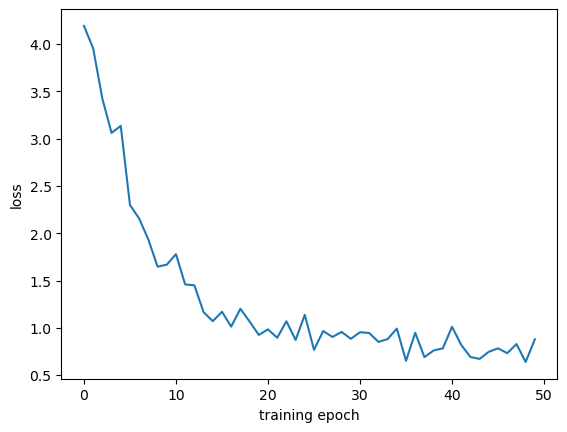

In [20]:
# 训练TransformerLM，由于不再采取批次训练，因此不再使用RNNLM和data_loader
def train_transformer_lm(data, model, epochs=50, learning_rate=1e-3):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.zero_grad()
    model.train()
    
    epoch_loss = []
    with trange(epochs, desc='epoch', ncols=60) as pbar:
        for epoch in pbar:
            step_loss = []
            np.random.shuffle(data)
            for step, x in enumerate(data):
                loss = model(torch.tensor(x, dtype=torch.long))
                pbar.set_description(f'epoch-{epoch},'+\
                    f' loss={loss.item():.4f}')
                loss.backward()
                grad_clipping(model)
                optimizer.step()
                model.zero_grad()
                step_loss.append(loss.item())
            # 本章前面的模型训练使用batch_size为16，
            # TransformerLM出于简便实现只能使用batch_size为1
            # 因此TransformerLM每一步的损失方差会更大，
            # 为便于对比，取每个epoch最后16个样本的平均损失
            epoch_loss.append(np.mean(step_loss[-16:]))
    
    epoch_loss = np.array(epoch_loss)
    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.xlabel('training epoch')
    plt.ylabel('loss')
    plt.show()
    
sent_tokens = dataset.convert_tokens_to_ids()
max_len=40
for i, tokens in enumerate(sent_tokens):
    tokens = tokens[:max_len]
    tokens += [0] * (max_len - len(tokens))
    sent_tokens[i] = tokens
sent_tokens = np.array(sent_tokens)

model = TransformerLM(vocab_size, max_len=40, hidden_size=128,\
    num_layers=1, num_heads=4, dropout=0., intermediate_size=512)
train_transformer_lm(sent_tokens, model)